<a href="https://colab.research.google.com/github/hj56775/Study_GAN/blob/main/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8장: CGAN

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/gans-in-action/blob/master/chapter-8/Chapter_8_CGAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                                     Embedding, Flatten, Input, Multiply, Reshape)
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

# 입력 이미지 차원
img_shape = (img_rows, img_cols, channels)

# 생성자 입력으로 사용될 잡음 벡터 크기
z_dim = 100

# 데이터셋에 있는 클래스 개수
num_classes = 10

## 생성자

In [ ]:
def build_generator(z_dim):

    model = Sequential()

    # 완전 연결 층을 사용해 입력을 7×7×256 텐서로 변환합니다.
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # 7×7×256에서 7×7×128 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(128, kernel_size=3, strides=1, padding='same'))

    # 배치 정규화
    model.add(BatchNormalization())

    # LeakyReLU 활성화
    model.add(LeakyReLU(alpha=0.01))

    # 7×7×128에서 14×14×128 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # 배치 정규화
    model.add(BatchNormalization())

    # LeakyReLU 활성화
    model.add(LeakyReLU(alpha=0.01))

    # 14×14×128에서 14×14×64 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # 배치 정규화
    model.add(BatchNormalization())

    # LeakyReLU 활성화
    model.add(LeakyReLU(alpha=0.01))

    '''14,14,64->14,14,32'''
    model.add(Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))

    # 배치 정규화
    model.add(BatchNormalization())

    # LeakyReLU 활성화
    model.add(LeakyReLU(alpha=0.01))

    # 14×14×64에서 28×28×1 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # tanh 활성화 함수
    model.add(Activation('tanh'))

    return model

In [ ]:
def build_cgan_generator(z_dim):

    # 랜덤 잡음 벡터 z
    z = Input(shape=(z_dim, ))

    # 조건 레이블: 정수 0-9까지 생성자가 만들 숫자
    label = Input(shape=(1, ), dtype='int32')

    # 레이블 임베딩: 
    # ----------------
    # 레이블을 z_dim 크기 밀집 벡터로 변환하고 
    # (batch_size, 1, z_dim) 크기 3D 텐서를 만듭니다.
    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)

    # 임베딩된 3D 텐서를 펼쳐서 (batch_size, z_dim) 크기 2D 텐서로 바꿉니다.
    label_embedding = Flatten()(label_embedding)

    # 벡터 z와 레이블 임베딩의 원소별 곱셈
    joined_representation = Multiply()([z, label_embedding])

    generator = build_generator(z_dim)

    # 주어진 레이블에 대한 이미지 생성
    conditioned_img = generator(joined_representation)

    return Model([z, label], conditioned_img)

## 판별자

In [ ]:
def build_discriminator(img_shape):

    model = Sequential()

    # 28×28×2에서 14×14×64 텐서로 바꾸는 합성곱 층
    '''#28,28,2->14,14,16'''
    model.add(
        Conv2D(16,
               kernel_size=3,
               strides=2,
               input_shape=(img_shape[0], img_shape[1], img_shape[2] + 1),
               padding='same'))
    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))


    '''#14,14,16->14,14,32'''
    model.add(Conv2D(32,kernel_size=3,strides=1,padding='same'))
    model.add(LeakyReLU(alpha=0.01))


    '''#14,14,32->7,7,32'''
    model.add(Conv2D(32,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU(alpha=0.01))



    # 14×14×64에서 7×7×64 텐서로 바꾸는 합성곱 층
    '''#7,7,32->7,7,64'''
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=1,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 7×7×64에서 3×3×128 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 시그모이드 활성화 함수를 사용한 출력층
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
def build_cgan_discriminator(img_shape):

    # 입력 이미지
    img = Input(shape=img_shape)

    # 입력 이미지의 레이블
    label = Input(shape=(1, ), dtype='int32')

    # 레이블 임베딩: 
    # ----------------
    # 레이블을 z_dim 크기의 밀집 벡터로 변환하고 
    # (batch_size, 1, 28×28×1) 크기의 3D 텐서를 만듭니다.
    label_embedding = Embedding(num_classes,
                                np.prod(img_shape),
                                input_length=1)(label)

    # 임베딩된 3D 텐서를 펼쳐서 (batch_size, 28×28×1) 크기의 2D 텐서를 만듭니다.
    label_embedding = Flatten()(label_embedding)

    # 레이블 임베딩 크기를 입력 이미지 차원과 동일하게 만듭니다.
    label_embedding = Reshape(img_shape)(label_embedding)

    # 이미지와 레이블 임베딩을 연결합니다.
    concatenated = Concatenate(axis=-1)([img, label_embedding])

    discriminator = build_discriminator(img_shape)

    # 이미지-레이블 쌍을 분류합니다.
    classification = discriminator(concatenated)

    return Model([img, label], classification)

## 모델 만들기

In [ ]:
def build_cgan(generator, discriminator):

    # 랜덤 잡음 벡터 z
    z = Input(shape=(z_dim, ))

    # 이미지 레이블
    label = Input(shape=(1, ))

    # 레이블에 맞는 이미지 생성하기
    img = generator([z, label])

    classification = discriminator([img, label])

    # 생성자 -> 판별자 연결 모델 
    # G([z, label]) = x* 
    # D(x*) = 분류
    model = Model([z, label], classification)

    return model

In [ ]:
# 판별자 만들고 컴파일하기
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=0.00001),
                      metrics=['accuracy'])

# 생성자 만들기
generator = build_cgan_generator(z_dim)

# 생성자를 훈련하는 동안 판별자 모델 파라미터를 고정하기
discriminator.trainable = False

# 생성자를 훈련하기 위해 고정된 판별자로 CGAN 모델 만들고 컴파일하기
cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

## 훈련

In [ ]:
accuracies = []
losses = []


def train(iterations, batch_size, sample_interval):

    # MNIST 데이터셋을 로드합니다.
    (X_train, y_train), (_, _) = mnist.load_data()

    # [0, 255] 사이 흑백 픽셀 값을 [–1, 1]로 스케일 변환합니다.
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # 진짜 이미지의 레이블: 모두 1
    real = np.ones((batch_size, 1))

    # 가짜 이미지의 레이블: 모두 0
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  판별자를 훈련합니다.
        # -------------------------

        # 진짜 이미지와 레이블로 이루어진 랜덤한 배치를 얻습니다.
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        # 가짜 이미지 배치를 생성합니다.
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict([z, labels])

        # 판별자를 훈련합니다.
        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  생성자를 훈련합니다.
        # ---------------------

        # 잡음 벡터의 배치를 생성합니다.
        z = np.random.normal(0, 1, (batch_size, z_dim))

        # 랜덤한 레이블의 배치를 얻습니다.
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        # 생성자를 훈련합니다.
        g_loss = cgan.train_on_batch([z, labels], real)

          


        if (iteration + 1) % sample_interval == 0:

            # 훈련 과정을 출력합니다.
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))

            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도를 저장합니다.
            losses.append((d_loss[0], g_loss))
            accuracies.append(100 * d_loss[1])

            # 생성한 이미지 샘플을 출력합니다.
            sample_images()

In [ ]:
def sample_images(image_grid_rows=2, image_grid_columns=5):

    # 랜덤한 잡음을 샘플링합니다.
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 0–9 사이의 이미지 레이블을 만듭니다.
    labels = np.arange(0, 10).reshape(-1, 1)

    # 랜덤한 잡음에서 이미지를 생성합니다.
    gen_imgs = generator.predict([z, labels])

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일을 변환합니다.
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드를 설정합니다.
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드를 출력합니다.
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % labels[cnt])
          
            cnt += 1
    plt.show()

# 모델을 훈련하고 훈련 과정 확인하기

11493376/11490434 [==============================] - 0s 0us/step
1000 [D loss: 0.700969, acc.: 50.00%] [G loss: 0.643781]


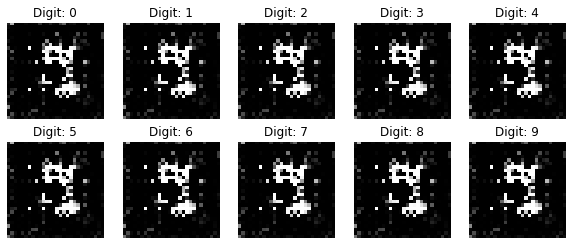

2000 [D loss: 0.707708, acc.: 35.94%] [G loss: 0.631244]


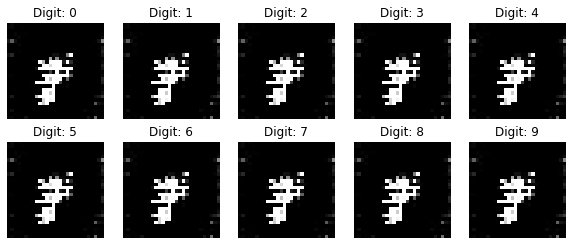

3000 [D loss: 0.692133, acc.: 32.81%] [G loss: 0.663000]


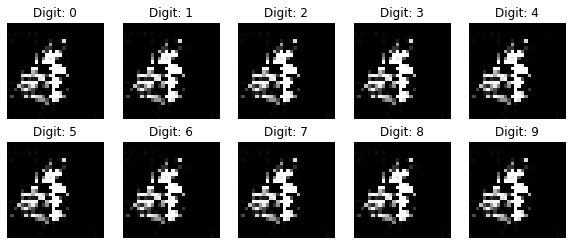

4000 [D loss: 0.670083, acc.: 93.75%] [G loss: 0.709023]


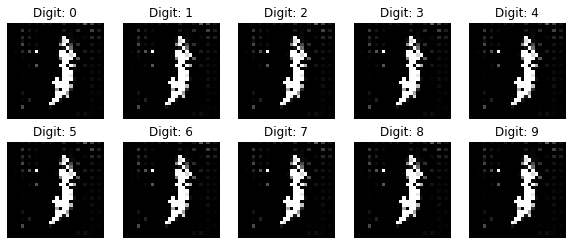

5000 [D loss: 0.678004, acc.: 76.56%] [G loss: 0.719173]


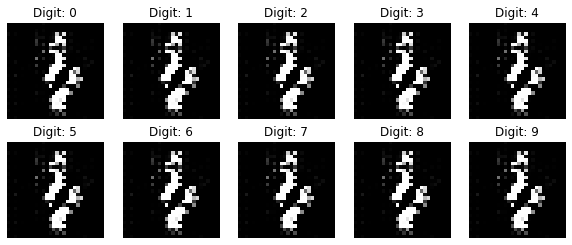

6000 [D loss: 0.674852, acc.: 89.06%] [G loss: 0.678084]


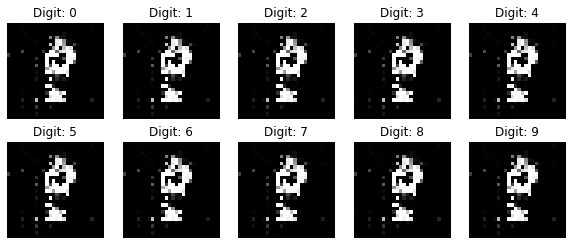

7000 [D loss: 0.730663, acc.: 25.00%] [G loss: 0.626705]


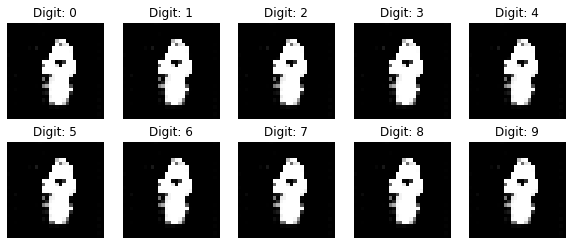

8000 [D loss: 0.637924, acc.: 96.88%] [G loss: 0.695467]


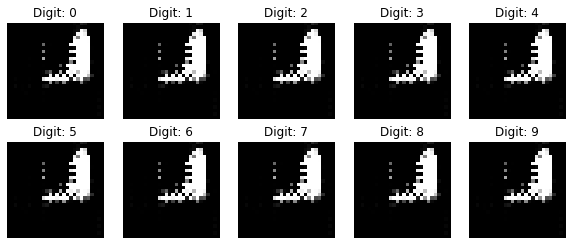

9000 [D loss: 0.692717, acc.: 28.12%] [G loss: 0.688462]


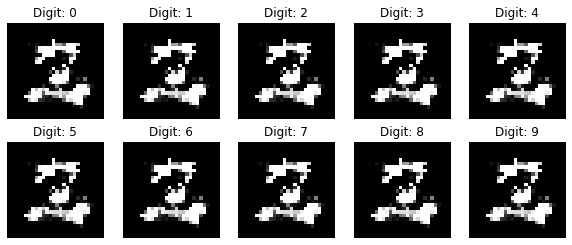

10000 [D loss: 0.664624, acc.: 73.44%] [G loss: 0.745912]


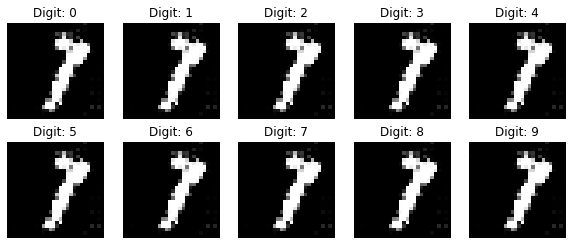

11000 [D loss: 0.667369, acc.: 70.31%] [G loss: 0.689058]


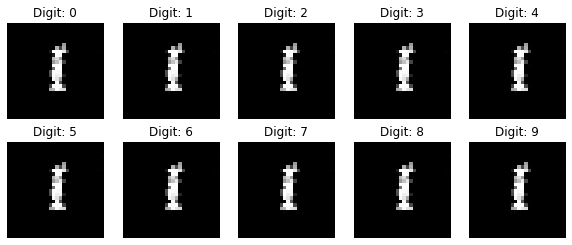

12000 [D loss: 0.673553, acc.: 46.88%] [G loss: 0.666584]


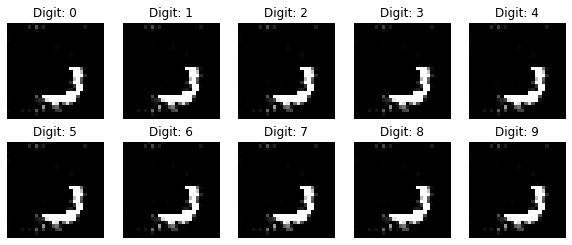

13000 [D loss: 0.635534, acc.: 89.06%] [G loss: 0.759608]


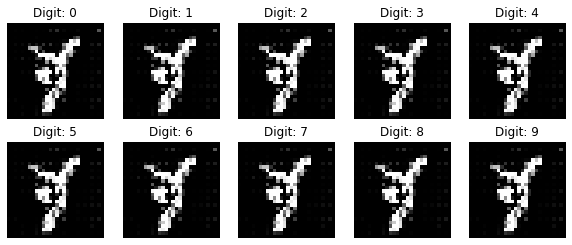

14000 [D loss: 0.648985, acc.: 79.69%] [G loss: 0.744595]


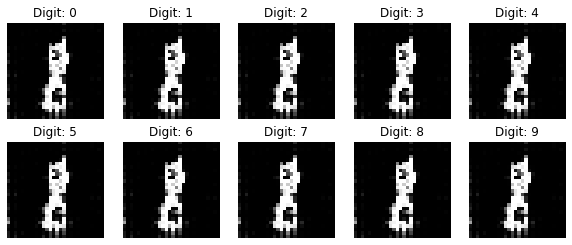

15000 [D loss: 0.648390, acc.: 85.94%] [G loss: 0.714189]


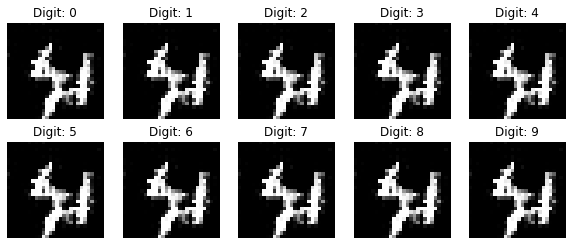

16000 [D loss: 0.667167, acc.: 79.69%] [G loss: 0.709677]


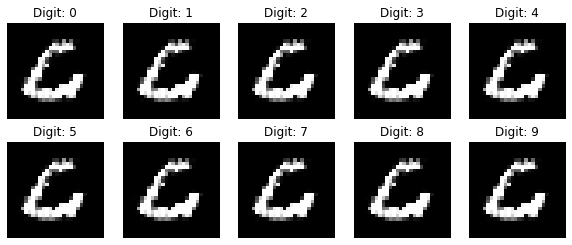

17000 [D loss: 0.682553, acc.: 64.06%] [G loss: 0.696249]


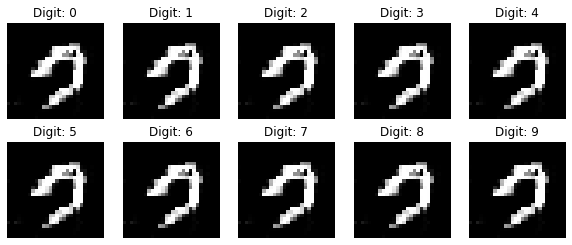

18000 [D loss: 0.567549, acc.: 93.75%] [G loss: 0.766198]


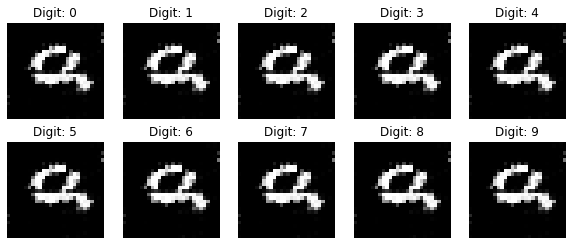

19000 [D loss: 0.712637, acc.: 46.88%] [G loss: 0.792175]


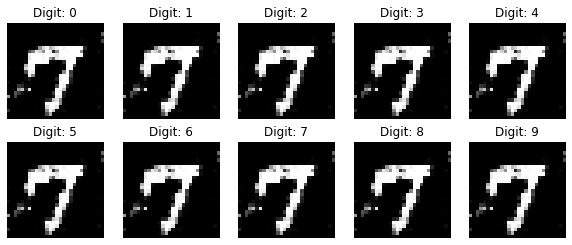

20000 [D loss: 0.633412, acc.: 60.94%] [G loss: 0.696746]


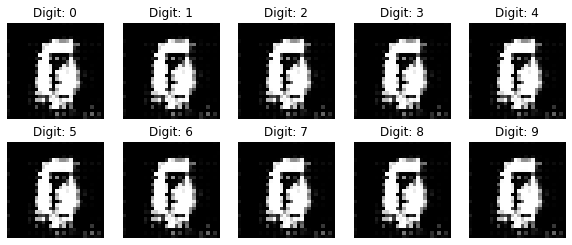

21000 [D loss: 0.778074, acc.: 32.81%] [G loss: 0.629870]


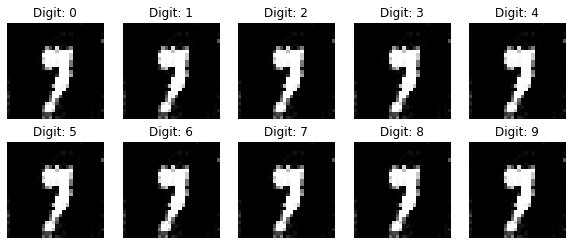

22000 [D loss: 0.524856, acc.: 87.50%] [G loss: 0.837008]


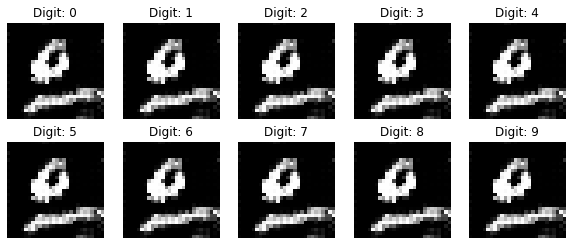

23000 [D loss: 0.495867, acc.: 92.19%] [G loss: 0.860830]


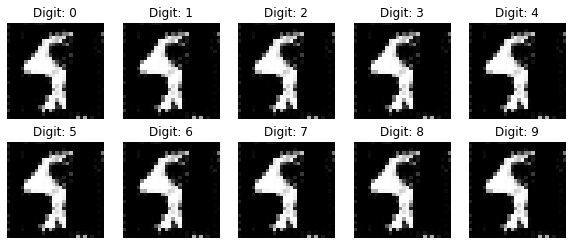

24000 [D loss: 0.548662, acc.: 73.44%] [G loss: 0.861796]


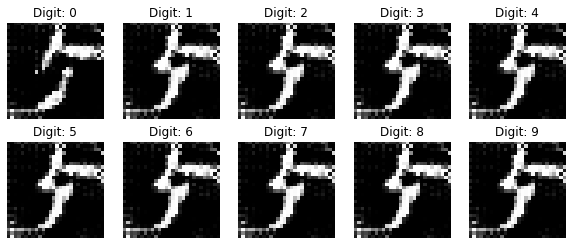

25000 [D loss: 0.741245, acc.: 43.75%] [G loss: 0.658184]


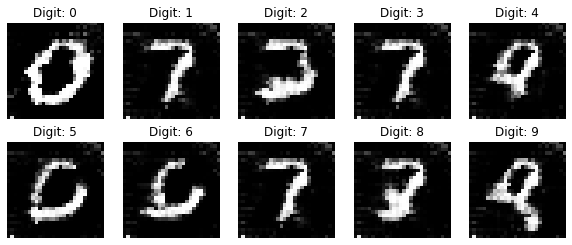

26000 [D loss: 0.769862, acc.: 26.56%] [G loss: 0.606475]


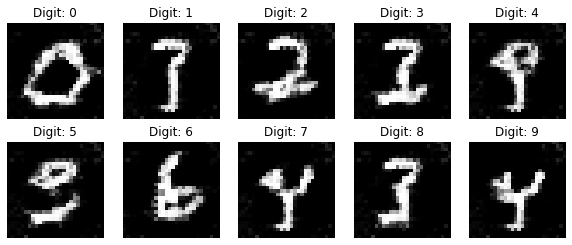

27000 [D loss: 0.758801, acc.: 28.12%] [G loss: 0.640660]


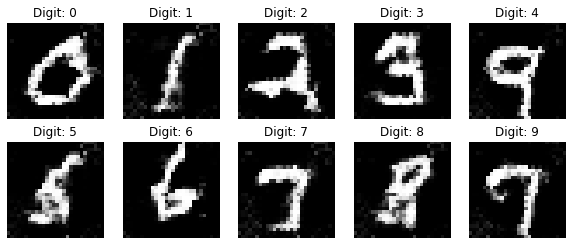

28000 [D loss: 0.744799, acc.: 14.06%] [G loss: 0.663082]


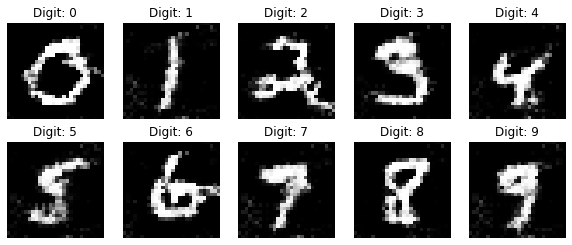

29000 [D loss: 0.723878, acc.: 18.75%] [G loss: 0.674749]


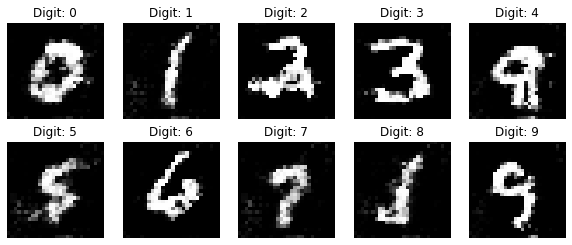

30000 [D loss: 0.711696, acc.: 28.12%] [G loss: 0.671070]


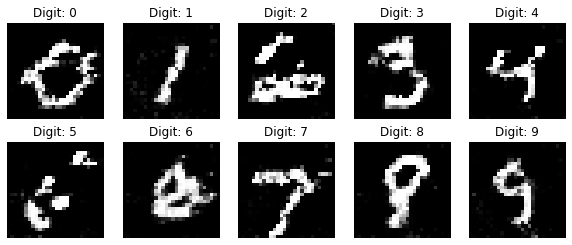

31000 [D loss: 0.709685, acc.: 10.94%] [G loss: 0.670290]


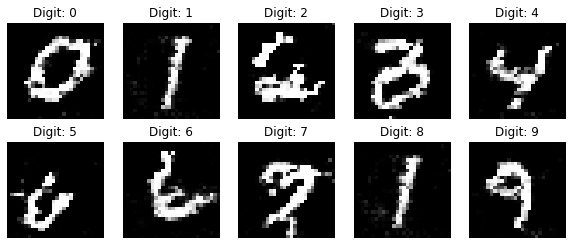

32000 [D loss: 0.703945, acc.: 29.69%] [G loss: 0.673735]


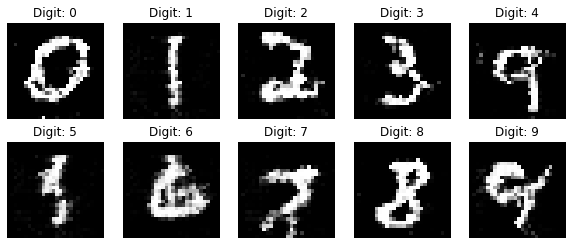

33000 [D loss: 0.705105, acc.: 17.19%] [G loss: 0.682694]


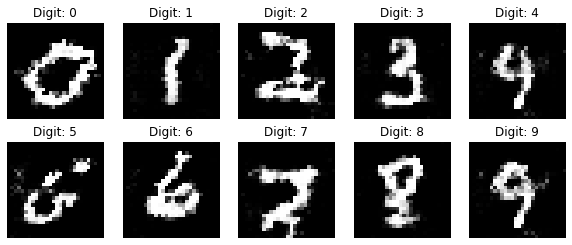

34000 [D loss: 0.704130, acc.: 28.12%] [G loss: 0.680892]


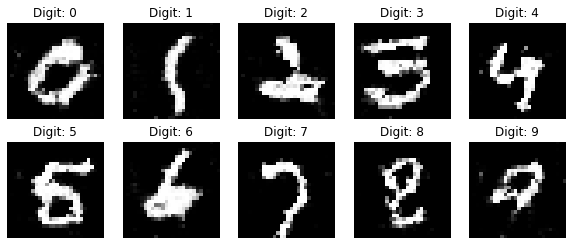

35000 [D loss: 0.705939, acc.: 25.00%] [G loss: 0.679953]


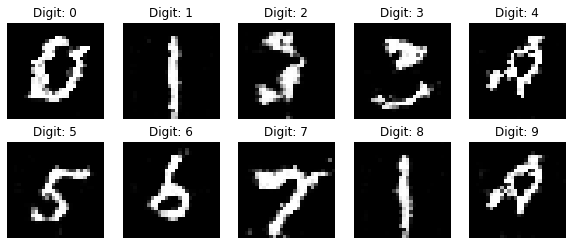

36000 [D loss: 0.703510, acc.: 26.56%] [G loss: 0.682903]


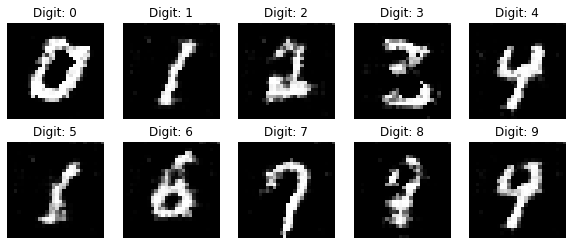

37000 [D loss: 0.701012, acc.: 29.69%] [G loss: 0.685009]


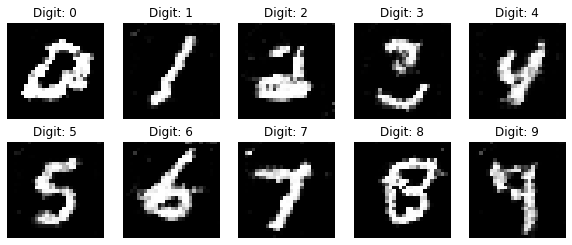

38000 [D loss: 0.698588, acc.: 29.69%] [G loss: 0.683899]


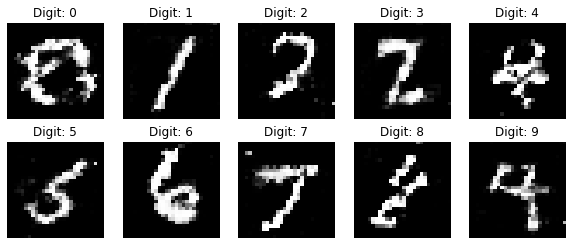

39000 [D loss: 0.700395, acc.: 23.44%] [G loss: 0.683553]


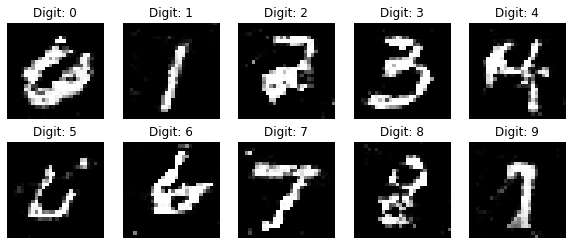

40000 [D loss: 0.699373, acc.: 26.56%] [G loss: 0.693383]


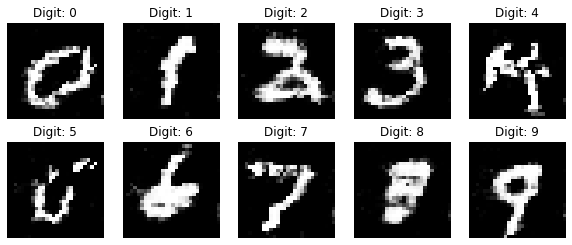

In [ ]:
# 하이퍼파라미터를 설정합니다.
iterations = 40000
batch_size = 32
sample_interval = 1000

# 지정된 반복 횟수 동안 CGAN을 훈련합니다.
train(iterations, batch_size, sample_interval)

In [ ]:
'''from keras.models import load_model
from google.colab.patches import cv2_imshow
model = load_model('/content/drive/MyDrive/화장 프로젝트/weight 코드/CGAN-MNIST/CGAN19999000.h5',compile=False)
z = np.random.normal(0, 1, (10, z_dim))
labels = np.array([5]*10).reshape(-1, 1)
gen_imgs=model.predict([z,labels])
gen_imgs = 0.5 * gen_imgs + 0.5

for i in range(10):
  plt.figure(figsize=(1,1))
  plt.imshow(gen_imgs[i,:,:,0],cmap='gray')
  plt.show()
'''



OSError: ignored

# 훈련된 CGAN 모델의 출력

In [ ]:
# 그리드 차원을 설정합니다.
image_grid_rows = 10
image_grid_columns = 5

# 랜덤한 잡음을 샘플링합니다.
z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

# 생성할 이미지 레이블을 5개씩 준비합니다.
labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
labels_to_generate = labels_to_generate.flatten().reshape(-1, 1)

# 랜덤한 잡음에서 이미지를 생성합니다.
gen_imgs = generator.predict([z, labels_to_generate])

# 이미지 픽셀 값을 [0, 1] 사이로 스케일을 변환합니다.
gen_imgs = 0.5 * gen_imgs + 0.5

# 이미지 그리드를 설정합니다.
fig, axs = plt.subplots(image_grid_rows,
                        image_grid_columns,
                        figsize=(10, 20),
                        sharey=True,
                        sharex=True)

cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # 이미지 그리드를 출력합니다.
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title("Digit: %d" % labels_to_generate[cnt])  ## NEW
        cnt += 1